In [1]:
import scanpy as sc
import anndata as ad
import squidpy as sq

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
bm_sp = sc.read_visium("../data/M1_tib_1A/outs/")


/Users/medinils/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [35]:
bm_sp.obs["array_col"]
bm_sp.obs["array_col"] = pd.to_numeric(bm_sp.obs["array_col"])
bm_sp.obs["array_row"] = pd.to_numeric(bm_sp.obs["array_row"])
bm_sp.obs["in_tissue"] = pd.to_numeric(bm_sp.obs["array_row"])


In [36]:
bm_sp
x = bm_sp
x.var_names_make_unique()
x.var["mt"] = x.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(x, qc_vars=["mt"], inplace=True)
x

AnnData object with n_obs × n_vars = 832 × 19407
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

In [37]:
a = x.obsm["spatial"]
a.dtype 
a = a.astype(np.int64)
a.dtype 
x.obsm["spatial"] = a

In [ ]:
sc.pp.filter_cells(x, min_counts=100)
sc.pp.filter_cells(x, max_counts=2500)
print(f"#cells after MT filter: {x.n_obs}")

In [38]:
sc.pp.normalize_total(x, inplace=True)
sc.pp.log1p(x)
sc.pp.highly_variable_genes(x, flavor="seurat", n_top_genes=2000)
sc.pp.pca(x)
sc.pp.neighbors(x,n_neighbors=20, n_pcs=20)
sc.tl.umap(x,min_dist= 0.7, spread=0.7, n_components=5)
sc.tl.leiden(x, key_added="clusters")
x

AnnData object with n_obs × n_vars = 832 × 19407
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'clusters'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatial', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [33]:
spatial_key = "spatial"
library_id = 'M1_tib_1A'
x.uns[spatial_key] = {library_id: {}}
#x.uns[spatial_key][library_id]["images"] = {}
#x.uns[spatial_key][library_id]["images"] = {"hires": image}
x.uns[spatial_key][library_id]["scalefactors"] = {"tissue_hires_scalef": 0.11937448, 'fiducial_diameter_fullres': 209.12257140921156, 'spot_diameter_fullres': 129.45682991998814}


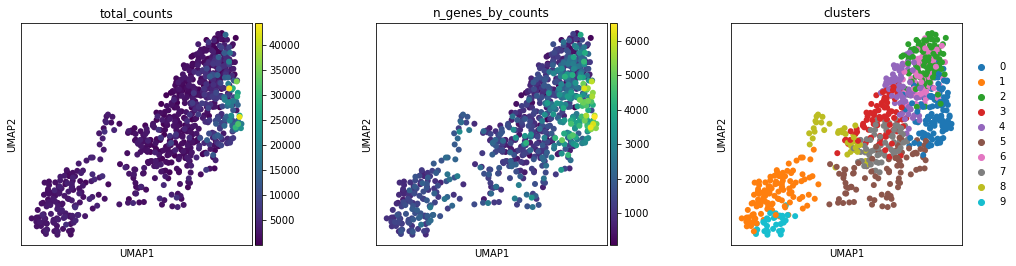

In [39]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(x, color=["total_counts", "n_genes_by_counts", "clusters"], wspace=0.4)

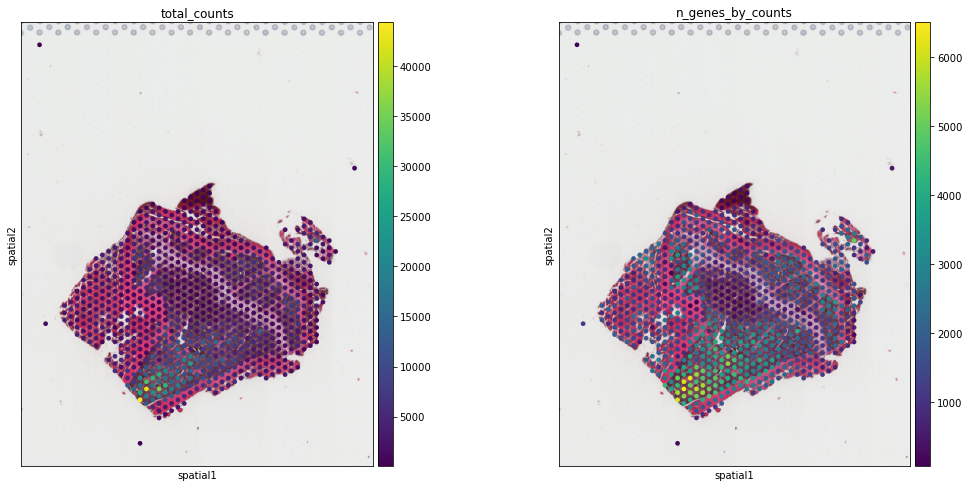

In [40]:
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(x, img_key="lowres", color=["total_counts", "n_genes_by_counts"])

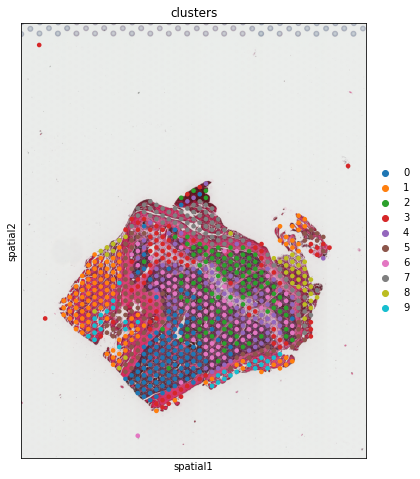

In [41]:
sc.pl.spatial(x, img_key="hires", color="clusters")

In [65]:
#CELL to CELL
res = sq.gr.ligrec(
    x,
    n_perms=1000,
    cluster_key="clusters",
    copy=True,
    use_raw=False,
    transmitter_params={"categories": "ligand"},
    receiver_params={"categories": "receptor"},
)

  0%|          | 0/1000 [00:00<?, ?permutation/s]

In [66]:
res["metadata"].head()

aspect_intercell_source aspect_intercell_target  \
source target                                                   
EPOR   TRPC3               functional              functional   
       JAK2                functional              functional   
FYN    JAK2                functional              functional   
CCL2   JAK2                functional              functional   
KIT    JAK2                functional              functional   

              category_intercell_source category_intercell_target  \
source target                                                       
EPOR   TRPC3                     ligand                  receptor   
       JAK2                      ligand                  receptor   
FYN    JAK2                      ligand                  receptor   
CCL2   JAK2                      ligand                  receptor   
KIT    JAK2                      ligand                  receptor   

              category_source_intercell_source  \
source target                                    
EPOR   TRPC3                 resource_specific   
       JAK2                  resource_specific   
FYN    JAK2                  resource_specific   
CCL2   JAK2                  resource_specific   
KIT    JAK2                  resource_specific   

              category_source_intercell_target  consensus_direction  \
source target                                                         
EPOR   TRPC3                 resource_specific                 True   
       JAK2                  resource_specific                False   
FYN    JAK2                  resource_specific                False   
CCL2   JAK2                  resource_specific                 True   
KIT    JAK2                  resource_specific                 True   

               consensus_inhibition  consensus_score_intercell_source  \
source target                                                           
EPOR   TRPC3                  False                                 1   
       JAK2                   False                                 1   
FYN    JAK2                   False                                 2   
CCL2   JAK2                   False                                18   
KIT    JAK2                   False                                 1   

               consensus_score_intercell_target  ...  scope_intercell_source  \
source target                                    ...                           
EPOR   TRPC3                                  3  ...                 generic   
       JAK2                                   1  ...                 generic   
FYN    JAK2                                   1  ...                 generic   
CCL2   JAK2                                   1  ...                 generic   
KIT    JAK2                                   1  ...                 generic   

               scope_intercell_target secreted_intercell_source  \
source target                                                     
EPOR   TRPC3                  generic                      True   
       JAK2                   generic                      True   
FYN    JAK2                   generic                     False   
CCL2   JAK2                   generic                      True   
KIT    JAK2                   generic                     False   

              secreted_intercell_target  \
source target                             
EPOR   TRPC3                      False   
       JAK2                       False   
FYN    JAK2                       False   
CCL2   JAK2                       False   
KIT    JAK2                       False   

                                              sources  \
source target                                           
EPOR   TRPC3                                     TRIP   
       JAK2              BioGRID;HPRD;SignaLink3;Wang   
FYN    JAK2                    HPRD;PhosphoPoint;Wang   
CCL2   JAK2                                      Wang   
KIT    JAK2    CancerCellMap;HPRD;NetP

In [67]:
res.keys()

dict_keys(['means', 'pvalues', 'metadata'])

/Users/medinils/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_baseplot_class.py:122: UserWarning: Over 500 categories found. Plot would be very large.
  warn(


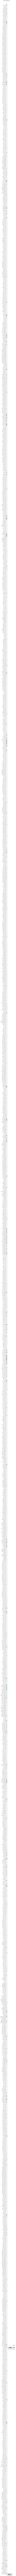

In [71]:
#plt.rcParams["figure.figsize"] = (8, 8)
sq.pl.ligrec(res, cluster_key= "2,6" ,source_groups ="6",target_groups ="2",remove_empty_interactions=True)#,
            #alpha=0.00005,
            #pval_threshold=0.00005,
            #figsize=(100, 300))
            #figsize (Optional[tuple[float, float]]))

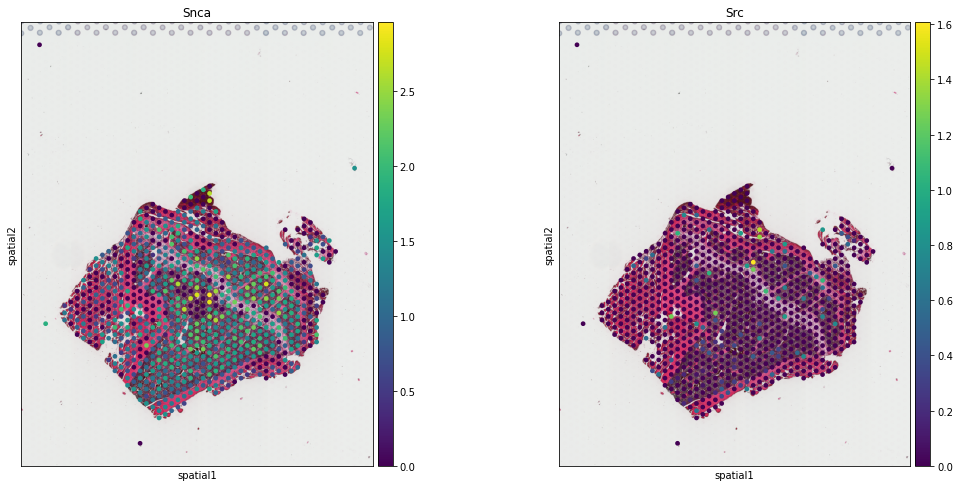

In [76]:
sc.pl.spatial(bm_sp, img_key="hires", color=["Snca", "Src"])